# Load modules

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

## imports
# general
import json
import pathlib
from copy import deepcopy
import itertools
from itertools import chain
import math
from functools import reduce

# data science
import numpy as np
import pandas as pd
# from scipy.stats import pearsonr
import scipy.cluster.hierarchy as sch
# from sklearn.linear_model import LinearRegression
import scikit_posthocs as sp # post-hoc tests for statistical analysis
from scipy.stats import pearsonr, spearmanr
import matplotlib as mpl  # main package for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# single cell
import anndata as ad  # main package for single cell data
import scanpy as sc  # main package for single cell analysis
import muon as mu  # package for multi-omic single cell data
import celltypist  # package for cell type annotation
import scirpy as ir # package for single cell receptor analysis
import scvi
import bbknn

# helpers
import os
import sys
sys.path.append('/home/divy/projects/jones-salim_tuning/thresholdpy')
import raval_preprocessing as rpp
import thresholdpy as tp

## settings
# set paths
PATH_PROJ_DIR = pathlib.Path(".")  # project directory
PATH_DATA_DIR = pathlib.Path(PATH_PROJ_DIR) / "data"
PATH_FIG_DIR = pathlib.Path(PATH_PROJ_DIR) / "figures" / "analysis"
PATH_EXPORT_DIR = pathlib.Path(PATH_PROJ_DIR) / "export" / "analysis"  # export directory
# create figures directory if it does not exist
PATH_FIG_DIR.mkdir(parents=True, exist_ok=True)
PATH_EXPORT_DIR.mkdir(parents=True, exist_ok=True)

FIG_TYPE = "svg"
DPI_SCALE = 300  # dpi scale for figures
FONT_SIZE = 10  # set font size for figures
sc.settings._file_format_figs = FIG_TYPE
# set scanpy settings
sc.settings.figdir = PATH_FIG_DIR  # set figure directory
# svg format, dpi, transparent background
sc.settings.set_figure_params(format=FIG_TYPE, dpi=DPI_SCALE, transparent=True, fontsize=FONT_SIZE)

# export matplotlib as svgs
# Set the global default figure size
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["pdf.fonttype"] = 42  # set font type for pdfs
plt.rcParams["ps.fonttype"] = 42  # set font type for postscript files
# plt.rcParams['figure.dpi'] = 600
# plt.rcParams['savefig.dpi'] = 600
# disable grid
mpl.rcParams["axes.grid"] = False  # disable grid in plots
plt.rcParams.update({"font.size": FONT_SIZE})  # set font size for matplotlib


# set random seed for reproducibility
SEED = 82
np.random.seed(SEED)  # set random seed for numpy

/home/divy/miniconda3/envs/sc-dense/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
adata_conde = ad.read_h5ad(
    PATH_DATA_DIR / f"Conde2022_t-cells.h5ad",
)
display(adata_conde)

# check type of X and scaling status
display(adata_conde.X)

AnnData object with n_obs × n_vars = 216611 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype'
    obsm: 'X_umap'

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 373601040 stored elements and shape (216611, 36601)>

## Check distribution of data to see if scaled

Most values near zero suggests it is indeed scaled (z-scored)

In [3]:
# plt.hist(np.mean(adata_conde[:10000, :].X, axis=0))
adata_conde.X[:1000, :].todense().mean(axis=0)
# plt.hist(np.mean(adata_conde.X[:1000, :], axis=0), bins = 25)

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.00240657,
         0.        ]], dtype=float32)

## Subset for faster processing

In [10]:
clusters = adata_conde.obs["Manually_curated_celltype"].unique()
display(clusters)
display(len(clusters))

# Subset to 3k cells per cluster to speed up processing
NUM = int(3e3)
subset_idxs = []
for cluster in clusters:
    cluster_cells_idxs = adata_conde.obs.index[
        adata_conde.obs["Manually_curated_celltype"] == cluster
    ]
    if len(cluster_cells_idxs) > NUM:
        subset_idxs.extend(
            cluster_cells_idxs[:NUM]
        )  # for reproducibility just use up to NUM indexes
    else:
        subset_idxs.extend(cluster_cells_idxs)

adata_conde_sub = adata_conde[subset_idxs].copy()  # type: ignore

# display(subset_idxs)
display(adata_conde_sub)

['Trm_Th1/Th17', 'Trm_gut_CD8', 'Trm_Tgd', 'T_CD4/CD8', 'Trm/em_CD8', ..., 'NK_CD16+', 'Tnaive/CM_CD8', 'MAIT', 'NK_CD56bright_CD16-', 'Tnaive/CM_CD4_activated']
Length: 18
Categories (18, object): ['Cycling T&NK', 'ILC3', 'MAIT', 'NK_CD16+', ..., 'Trm/em_CD8', 'Trm_Tgd', 'Trm_Th1/Th17', 'Trm_gut_CD8']

18

AnnData object with n_obs × n_vars = 51438 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Manually_curated_celltype'
    obsm: 'X_umap'

# Process Data

## Ridge regression

In [12]:
display(adata_conde_sub.X)
X_array = np.asarray(adata_conde_sub.X.todense())  # type: ignore
display(type(X_array))
adata_conde_sub.X = X_array
display(type(adata_conde_sub.X))
display(np.shape(adata_conde_sub.X))

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 87981758 stored elements and shape (51438, 36601)>

numpy.ndarray

numpy.ndarray

(51438, 36601)

In [13]:
bbknn.ridge_regression(
    adata_conde_sub,
    batch_key=["Chemistry"],
    confounder_key=["Predicted_labels_CellTypist"],
    # chunksize=1e6,
    random_state=SEED,
)

## Compute PCA

In [14]:
sc.pp.pca(adata_conde_sub)

## Nearest neighbors

In [15]:
bbknn.bbknn(adata_conde_sub, batch_key="Donor")

## Compute UMAP

In [16]:
if not "X_umap_old" in adata_conde_sub.obsm:
    adata_conde_sub.obsm["X_umap_old"] = adata_conde_sub.obsm["X_umap"]
sc.tl.umap(adata_conde_sub)

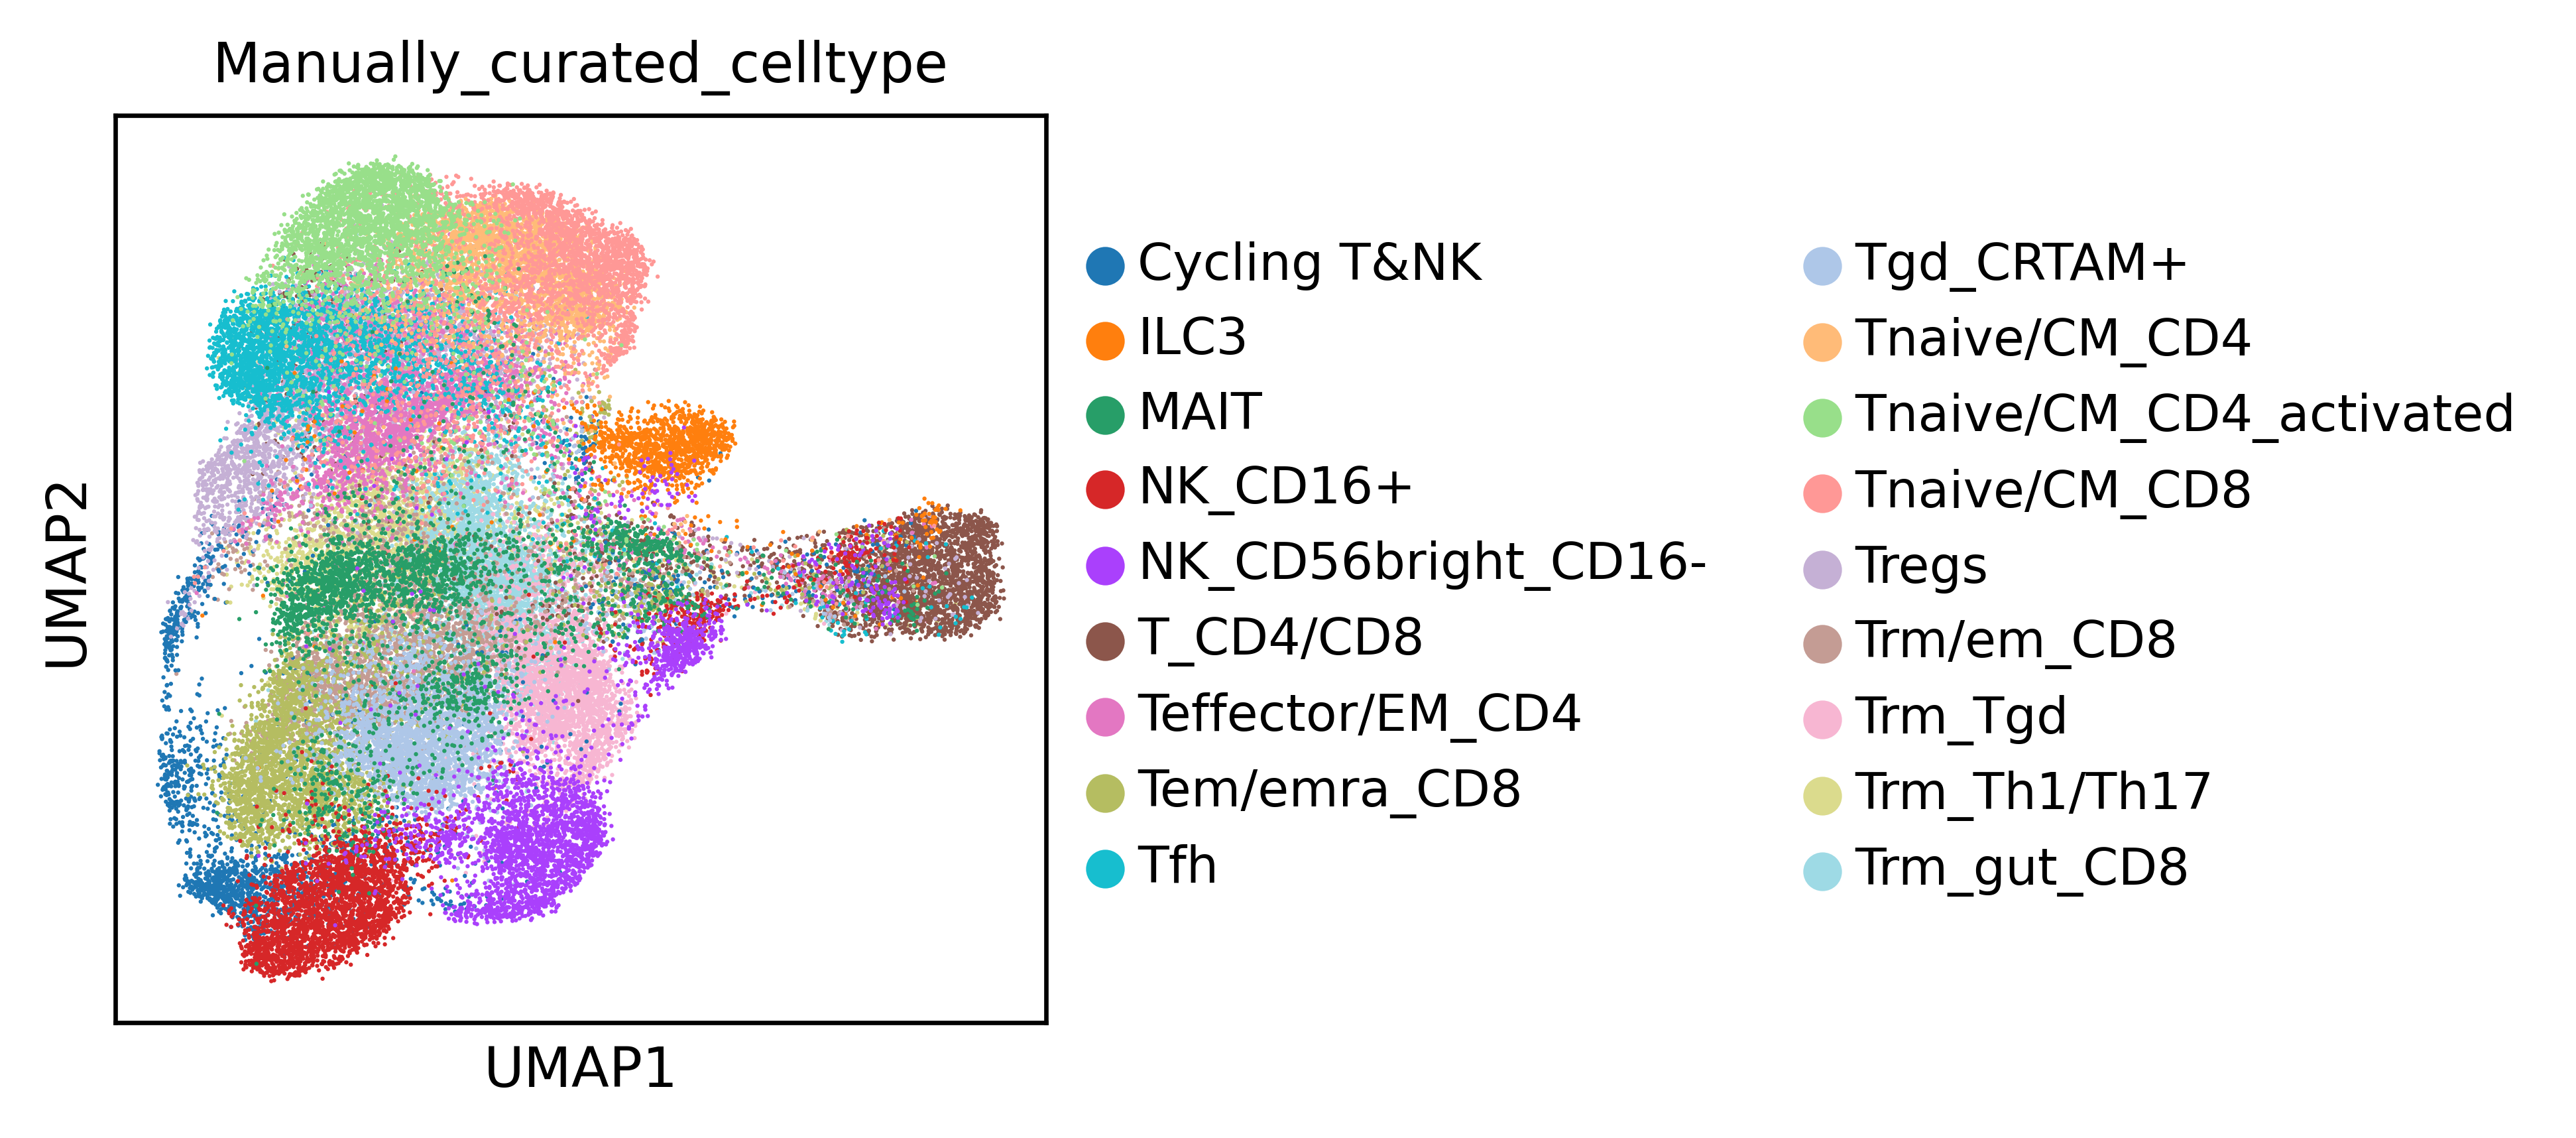

In [17]:
sc.pl.umap(
    adata_conde_sub,
    color="Manually_curated_celltype",
)

In [20]:
sc.pp.pca(adata_conde)

bbknn.bbknn(adata_conde, batch_key="Donor")

if not "X_umap_old" in adata_conde.obsm:
    adata_conde.obsm["X_umap_old"] = adata_conde.obsm["X_umap"]
sc.tl.umap(adata_conde)

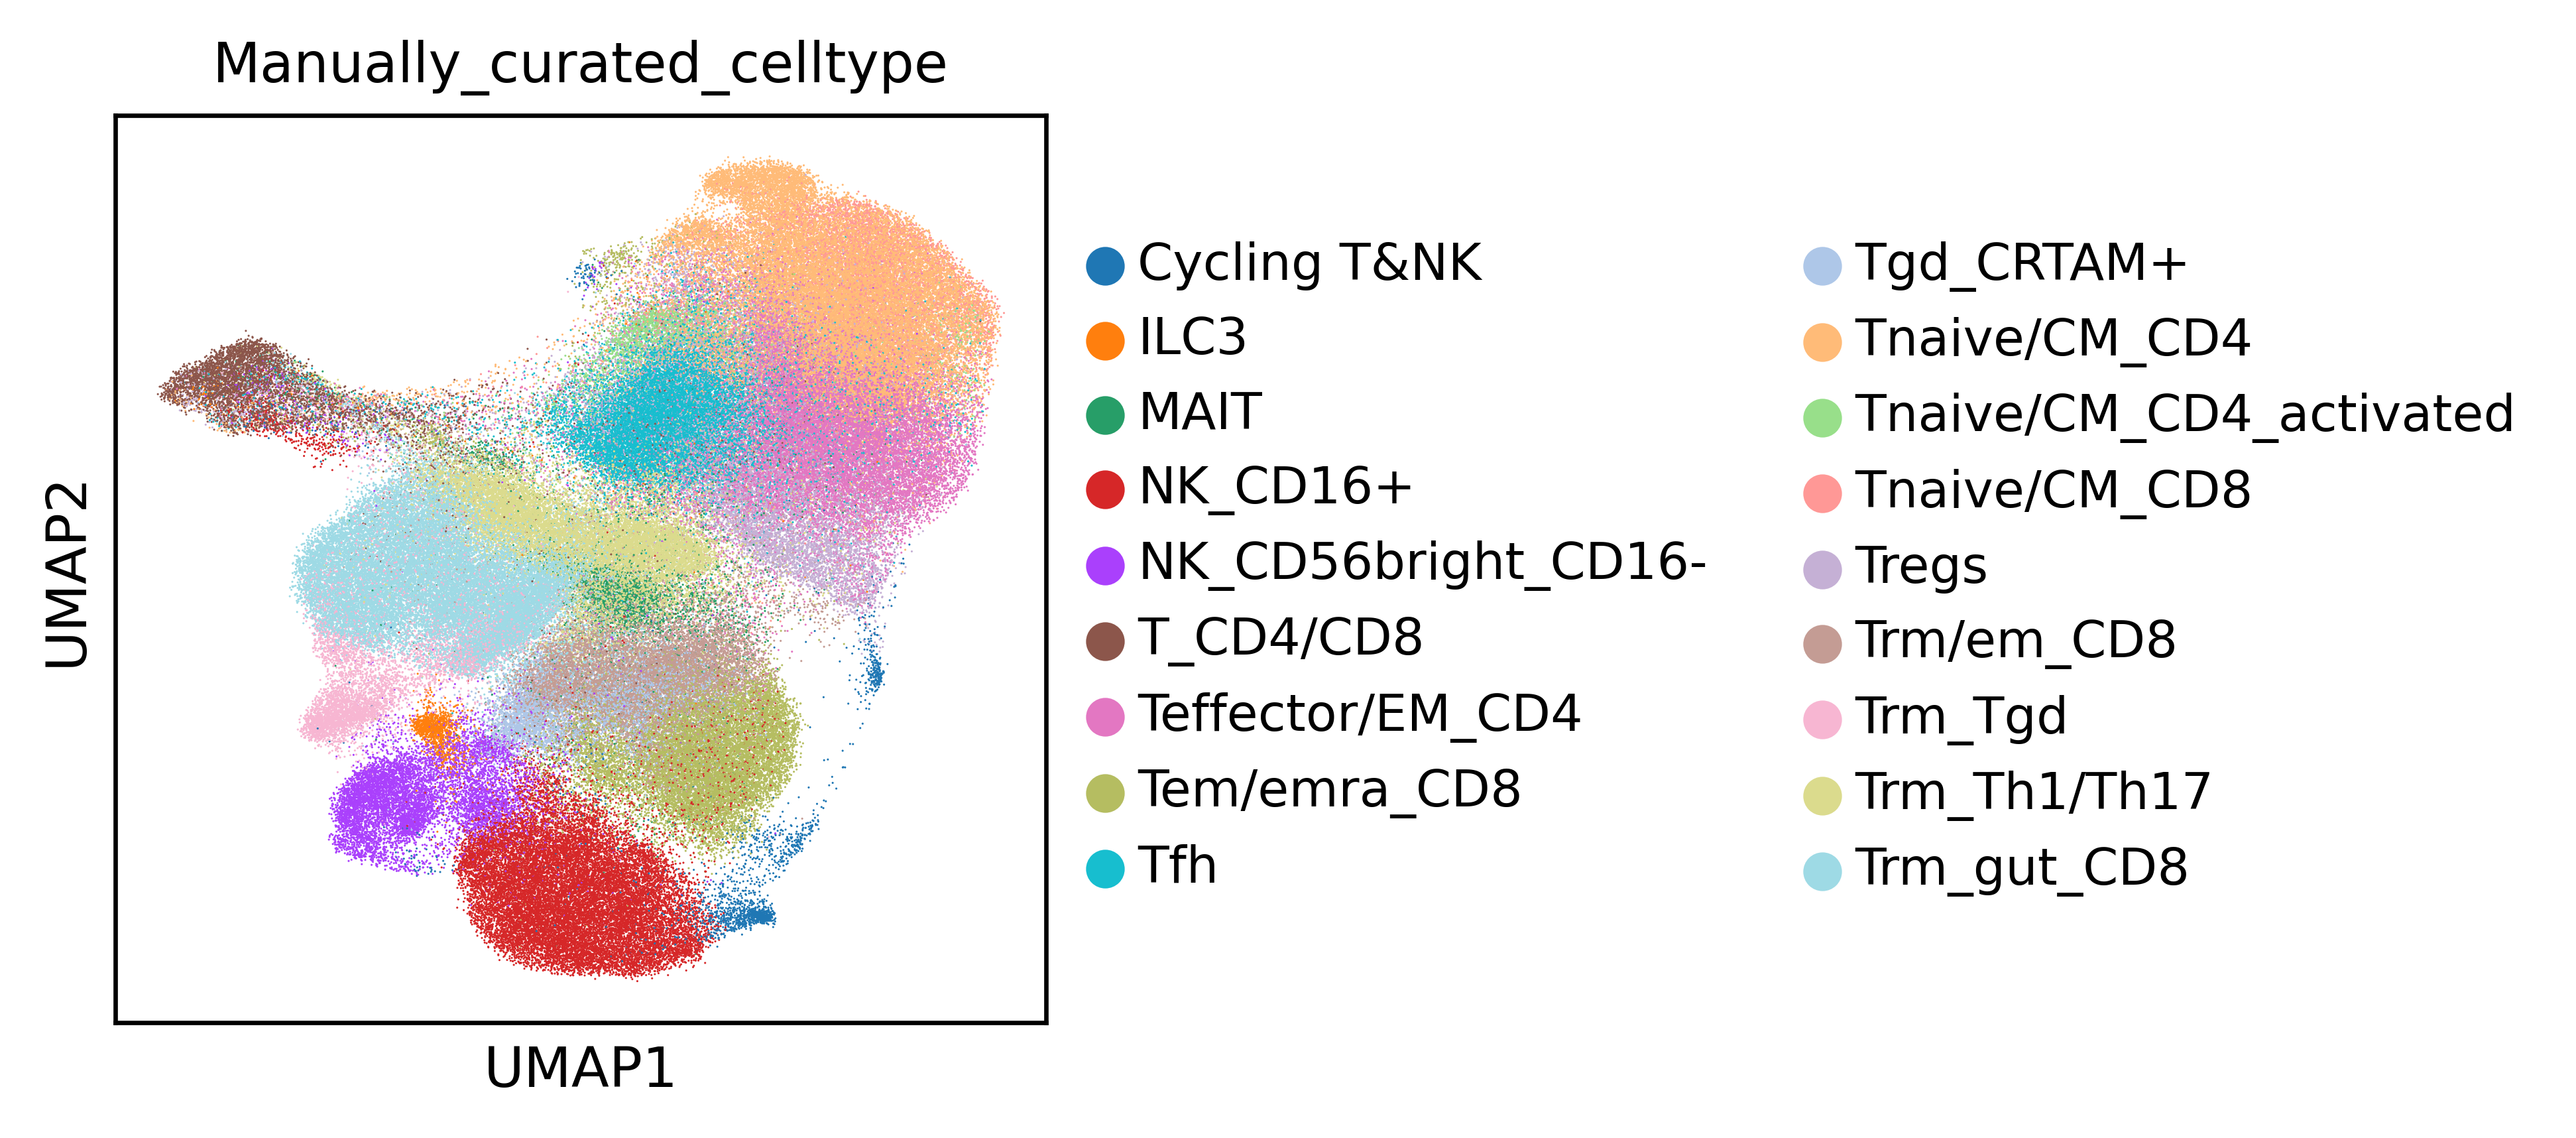

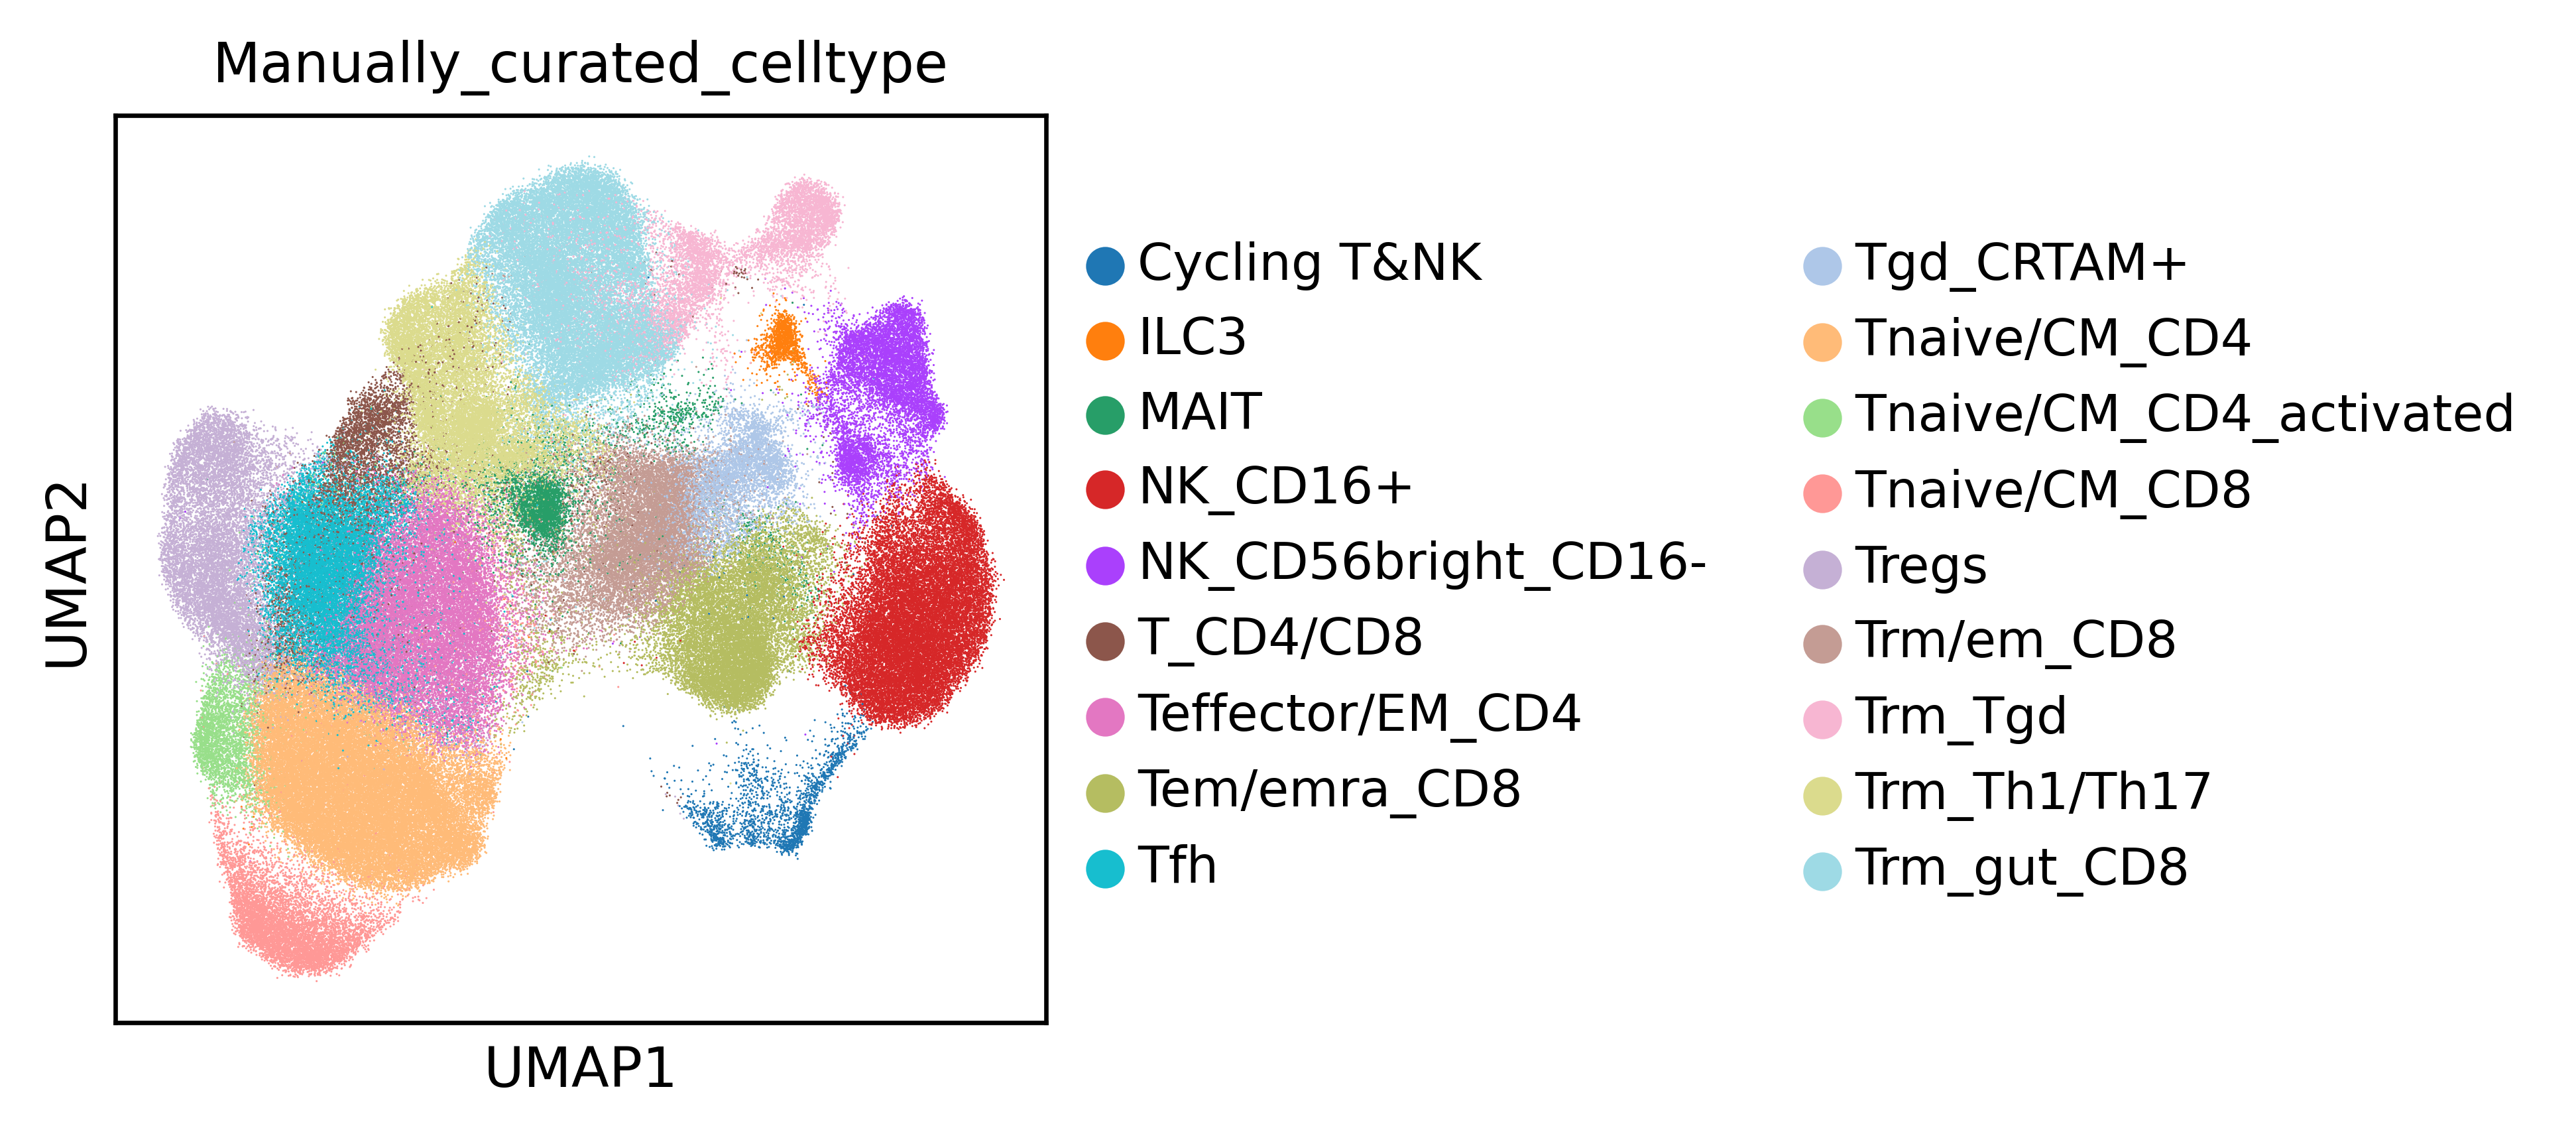

In [22]:
sc.pl.umap(
    adata_conde,
    color="Manually_curated_celltype",
)

adata_conde_old = adata_conde.copy()
adata_conde_old.obsm["X_umap"] = adata_conde_old.obsm["X_umap_old"]

sc.pl.umap(
    adata_conde_old,
    color="Manually_curated_celltype",
)

In [ ]:
adata_conde.uns["umap"], adata_conde_sub.uns["umap"]

({'params': {'a': 0.5830300203968329, 'b': 1.3341669926352966}},
 {'params': {'a': 0.5830300203968329, 'b': 1.3341669926352966}})